
# Explanation of the task:

This is the classic Emotion Recognition Classification task. Given a conversation, involving 2 or more parties, for each message/utterance, we want to predict an emotion related to it.


Consider the example:

**Person A**: "Hello! I am very happy" (happiness)

**Person B**: "Why? I am very angry"   (anger)

## First model idea:
- inputs: sequence of utterances, sequence of emotions.
- For each: Linear Layers
- Fusion model

- hidden layer

- Loss: cross-entropy



# Preprocessing:

Consider the each conversation as just a sequence of words:
$$
[[utt, utt, \cdots], \cdots ] \longrightarrow [[word, word , \cdots], \cdots]
$$

In here, we add a separator token "sep". It will serve to indicate when a utteration is over, and another one starts. We also add a padding token at the end to ensure that all inputs have same dimention.


In [1]:
! pip install nltk
! pip install torch
! pip install pandas
! pip install gensim
! pip install datasets
! pip install matplotlib
! pip install tqdm
! pip install torchinfo
! pip install requests json
# eventually include tensorboard

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [2]:
import torch
import os
import matplotlib.pyplot as plt
import gensim
import json
import requests
import heapq

from nltk.tokenize import TweetTokenizer
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from collections import Counter

import pandas as pd
import numpy as np

In [ ]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
! unzip wiki-news-300d-1M.vec.zip
! rm wiki-news-300d-1M.vec.zip

In [3]:
## taken from template
encoder_model = gensim.models.KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary = False)

In [4]:
## We create the embeddings and find the vocab
import copy
unk_token, sep_token = '<unk>', '<sep>'
embedding_vectors = torch.from_numpy(encoder_model.vectors) ## TODO: remove least frequent
pretrained_vocab = copy.deepcopy(encoder_model.index_to_key)
pretrained_vocab[:0] = [unk_token,sep_token]

stoi = {word: i for i, word in enumerate(pretrained_vocab)}
itos = {i: word for i, word in enumerate(pretrained_vocab)}

pretrained_embeddings = torch.cat((torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))
pretrained_embeddings = torch.cat((-torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))

In [5]:
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

max_size = 50
## By using the template that was shared, we can process the inputs in a very similar way
tok = TweetTokenizer()
def tokenize_text_extend_emotions(text,emotion,stoi): ## utteration : string -> list of tokenized words : [int]
  text = tok.tokenize(text)
  text = [stoi[word] if word in stoi else stoi['<unk>'] for word in text]
  return text, [emotion]*len(text)

def concat_utt(dialog, emotions, stoi): ## list of utterations : [string] -> list of list of tokenized words : [int]
  tokenized_and_extended = [tokenize_text_extend_emotions(t,e,stoi) for t,e in zip(dialog,emotions)]
  dialog = [i[0] for i in tokenized_and_extended]
  emotions = [i[1] for i in tokenized_and_extended]
  dialog_flat = []
  emotions_extended = []
  for i in range(len(dialog) - 1):
    dialog[i].append(stoi["<sep>"])
    emotions[i].append(7) ## number of emotions
  for i in range(len(dialog)):
    dialog_flat.extend(dialog[i])
    emotions_extended.extend(emotions[i])
  return dialog_flat,emotions_extended

def preprocess_data(X,Y,stoi): ## list of lists of utterations : [[string]] -> list of lists of tokenized words : [[int]]
  X_processed = []
  Y_processed = []
  for i in tqdm(range(len(X))):
    X_processed.append(concat_utt(X[i],Y[i],stoi)[0])
    Y_processed.append(concat_utt(X[i],Y[i],stoi)[1])
  return X_processed, Y_processed

def get_target(X,Y): ## generates the target values and input values
  text_input = [i[:-1] for i in X]
  text_target = [i[1:] for i in X]
  emotion_input = [i[:-1] for i in Y]
  emotion_target = [i[1:] for i in Y]
  return text_input, text_target, emotion_input, emotion_target


## Check the following example:
dialog_example = ["hello, I am a I robot!","I am greek"]
emotions_example = [1,2] ## random emotions...

flatten_dialog, flatten_emotions = concat_utt(dialog_example,emotions_example,stoi)
print(f"{dialog_example} becomes {flatten_dialog}")
print(f"{emotions_example} becomes {flatten_emotions}")


['hello, I am a I robot!', 'I am greek'] becomes [13171, 2, 30, 783, 9, 30, 6871, 79, 1, 30, 783, 22504]
[1, 2] becomes [1, 1, 1, 1, 1, 1, 1, 1, 7, 2, 2, 2]


## DataLoader:

In [6]:
## Modify this after changing the preprocessing.
class DailyDialogDataset(Dataset):
  def __init__(self, texts, emotions,target_texts,target_emotions):
  # Dataset object for Daily Dialog dataset
    self.texts = texts                     ## tokenized text
    self.emotions = emotions               ## tokenized emotions
    self.target_texts = target_texts       ## target text for loss computation
    self.target_emotions = target_emotions ## target emotions for loss computation

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
                'texts': np.array(self.texts[idx]),
             'emotions': np.array(self.emotions[idx]),
         'target_texts': np.array(self.target_texts[idx]),
      'target_emotions': np.array(self.target_emotions[idx])
    }
    return item
class MeldDataset(Dataset):
  def __init__(self, texts, emotions,target_texts,target_emotions):
  # Dataset object for MELD dataset
    self.texts = texts                     ## tokenized text
    self.emotions = emotions               ## tokenized emotions
    self.target_texts = target_texts       ## target text for loss computation
    self.target_emotions = target_emotions ## target emotions for loss computation

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
                'texts': np.array(self.texts[idx]),
             'emotions': np.array(self.emotions[idx]),
         'target_texts': np.array(self.target_texts[idx]),
      'target_emotions': np.array(self.target_emotions[idx])
    }
    return item
class EmorynlpDataset(Dataset):
  def __init__(self, texts, emotions,target_texts,target_emotions):
    # Dataset object for EmoryNLP dataset
    self.texts = texts                     ## tokenized text
    self.emotions = emotions               ## tokenized emotions
    self.target_texts = target_texts       ## target text for loss computation
    self.target_emotions = target_emotions ## target emotions for loss computation

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
                 'texts': np.array(self.texts[idx]),
              'emotions': np.array(self.emotions[idx]),
          'target_texts': np.array(self.target_texts[idx]),
      'target_emotions' : np.array(self.target_emotions[idx])
    }
    return item


Here we will extract the data and process it:

In [7]:
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/dev_sent_emo.csv
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/test_sent_emo.csv
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/train_sent_emo.csv

--2025-01-28 12:32:19--  https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/dev_sent_emo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121640 (119K) [text/plain]
Saving to: ‘dev_sent_emo.csv.9’

dev_sent_emo.csv.9  100%[===================>] 118.79K  --.-KB/s    in 0.02s   

2025-01-28 12:32:19 (5.85 MB/s) - ‘dev_sent_emo.csv.9’ saved [121640/121640]

--2025-01-28 12:32:19--  https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/test_sent_emo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting respo

In [8]:
#data_dd = load_dataset('daily_dialog') ## daily conversations

data_meld_train = pd.read_csv('train_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])
data_meld_val = pd.read_csv('dev_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])
data_meld_test = pd.read_csv('test_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])

## For Daily Dialog:
"""
X_train_dd = data_dd['train']['dialog']
Y_train_dd = data_dd['train']['emotion']
X_test_dd = data_dd['test']['dialog']
Y_test_dd = data_dd['test']['emotion']
X_val_dd = data_dd['validation']['dialog']
Y_val_dd = data_dd['validation']['emotion']
"""
## For MELD
def change_Y(Y,lookup=None):
  lookup = {} if lookup is None else lookup
  k = 0
  for i in range(len(Y)):
    for j in range(len(Y[i])):
      if Y[i][j] not in lookup:
        lookup[Y[i][j]] = k
        Y[i][j] = k
        k += 1
      else:
        Y[i][j] = lookup[Y[i][j]]
  return Y, lookup


def parse_meld(df,lookup = None):
  X, Y = {}, {}
  for _, row in df.iterrows():
    dialog_id = row['Dialogue_ID']
    if dialog_id not in X:
      X[dialog_id] = []
      Y[dialog_id] = []
    X[dialog_id].append(row['Utterance'])
    Y[dialog_id].append(row['Emotion'])
  X = list(X.values())
  Y = list(Y.values())
  Y,lookup = change_Y(Y,lookup)
  return X, Y, lookup

X_train_meld, Y_train_meld, lookup_meld = parse_meld(data_meld_train)
X_test_meld, Y_test_meld, _ = parse_meld(data_meld_test,lookup_meld)
X_val_meld, Y_val_meld, _ = parse_meld(data_meld_val,lookup_meld)


## For EmoryNLP:
def parse_seasons(episodes,lookup=None): ## annoying parsing
  lookup = {} if lookup is None else lookup
  X = []
  Y = []
  for episode in episodes:
    for scene in episode['scenes']:
      dialog = []
      emotion = []
      for utterance in scene['utterances']:
        if utterance['transcript'] != '':
          dialog.append(utterance['transcript'])
          emotion.append(utterance['emotion'])
      X.append(dialog)
      Y.append(emotion)
  Y,lookup = change_Y(Y)
  return X, Y, lookup

def parse_emory(): ## getting from the web
  json_train = 'https://raw.githubusercontent.com/emorynlp/emotion-detection/refs/heads/master/json/emotion-detection-trn.json'
  json_test = 'https://raw.githubusercontent.com/emorynlp/emotion-detection/refs/heads/master/json/emotion-detection-dev.json'
  json_val = 'https://raw.githubusercontent.com/emorynlp/emotion-detection/refs/heads/master/json/emotion-detection-tst.json'
  train = requests.get(json_train)
  test = requests.get(json_test)
  val = requests.get(json_val)

  train = json.loads(train.text)['episodes']
  test = json.loads(test.text)['episodes']
  val = json.loads(val.text)['episodes']
  X_train, Y_train, lookup = parse_seasons(train)
  X_test, Y_test, _ = parse_seasons(test)
  X_val, Y_val, _ = parse_seasons(val)
  return X_train, Y_train, X_test, Y_test, X_val, Y_val, lookup


## to get top n most frequent words:


def get_topk(X,k): ## get the top k most frequent words - has to get a flatten version of the input
  X = [j for i in X for j in i]
  flat_X = [] 
  for i in X:
    flat_X.extend(tok.tokenize(i))
  c = Counter(flat_X)
  top_k = heapq.nlargest(k, c.items(), key=lambda x: x[1])
  new_stoi = {'<unk>' : 0, '<sep>' : 1}
  res = []
  k = 2
  for (word,_) in top_k:
    if word in stoi:
      new_stoi[word] = k
      k += 1
      res.append(pretrained_embeddings[stoi[word]])
  res[:0] = [torch.ones(embedding_vectors.shape[1]),-torch.ones(embedding_vectors.shape[1])]
  new_itos = {index : word for (word,index) in new_stoi.items()}
  return torch.stack(res), new_stoi, new_itos

X_train_emory, Y_train_emory, X_test_emory, Y_test_emory, X_val_emory, Y_val_emory, lookup_emory = parse_emory()
embeddings_emory, stoi_emory,itos_emory = get_topk(X_train_emory, 50000)


In [9]:
# For Daily Dialog (probably not going to be used anymore)
""" 
X_train_dd, Y_train_dd = preprocess_data(X_train_dd,Y_train_dd)
X_train_dd,X_train_target_dd, Y_train_dd, Y_train_target_dd = get_target(X_train_dd,Y_train_dd)
X_test_dd, Y_test_dd = preprocess_data(X_test_dd,Y_test_dd)
X_test_dd,X_test_target_dd, Y_test_dd, Y_test_target_dd = get_target(X_test_dd,Y_test_dd)
X_val_dd, Y_val_dd = preprocess_data(X_val_dd,Y_val_dd)
X_val_dd, X_val_target_dd, Y_val_dd, Y_val_target_dd = get_target(X_val_dd,Y_val_dd)
"""
# For MELD
"""
X_train_meld, Y_train_meld = preprocess_data(X_train_meld,Y_train_meld)
X_train_meld,X_train_target_meld, Y_train_meld, Y_train_target_meld = get_target(X_train_meld,Y_train_meld)
X_test_meld, Y_test_meld = preprocess_data(X_test_meld,Y_test_meld)
X_test_meld,X_test_target_meld, Y_test_meld, Y_test_target_meld = get_target(X_test_meld,Y_test_meld)
X_val_meld, Y_val_meld = preprocess_data(X_val_meld,Y_val_meld)
X_val_meld, X_val_target_meld, Y_val_meld, Y_val_target_meld = get_target(X_val_meld,Y_val_meld)
"""
## For EmoryNLP:
X_train_emory, Y_train_emory = preprocess_data(X_train_emory,Y_train_emory,stoi_emory)
X_train_emory,X_train_target_emory, Y_train_emory, Y_train_target_emory = get_target(X_train_emory,Y_train_emory)
X_test_emory, Y_test_emory = preprocess_data(X_test_emory,Y_test_emory,stoi_emory)
X_test_emory,X_test_target_emory, Y_test_emory, Y_test_target_emory = get_target(X_test_emory,Y_test_emory)
X_val_emory, Y_val_emory = preprocess_data(X_val_emory,Y_val_emory,stoi_emory)
X_val_emory, X_val_target_emory, Y_val_emory, Y_val_target_emory = get_target(X_val_emory,Y_val_emory)
## Just checking if nothing wrong happened



  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

In [10]:
batch_size = 1 ## try with other values. 5 Might be too little!
"""
train_data_dd = DailyDialogDataset(X_train_dd,Y_train_dd,X_train_target_dd,Y_train_target_dd)
test_data_dd = DailyDialogDataset(X_test_target_dd,Y_test_target_dd,X_test_target_dd,Y_test_target_dd)
val_data_dd = DailyDialogDataset(X_val_target_dd,Y_val_target_dd,X_val_target_dd,Y_val_target_dd)

train_data_meld = MeldDataset(X_train_meld,Y_train_meld,X_train_target_meld,Y_train_target_meld)
test_data_meld = MeldDataset(X_test_meld,Y_test_meld,X_test_target_meld,Y_test_target_meld)
val_data_meld = MeldDataset(X_val_meld,Y_val_meld,X_val_target_meld,Y_val_target_meld)
"""
train_data_emory = EmorynlpDataset(X_train_emory,Y_train_emory,X_train_target_emory,Y_train_target_emory)
test_data_emory = EmorynlpDataset(X_test_emory,Y_test_emory,X_test_target_emory,Y_test_target_emory)
val_data_emory = EmorynlpDataset(X_val_emory,Y_val_emory,X_val_target_emory,Y_val_target_emory)

"""
train_loader_dd = DataLoader(train_data_dd, batch_size=batch_size,shuffle = True,)
test_loader_dd = DataLoader(test_data_dd, batch_size=batch_size,shuffle = True)
val_loader_dd = DataLoader(val_data_dd, batch_size=batch_size, shuffle = True)

train_loader_meld = DataLoader(train_data_meld, batch_size=batch_size,shuffle = True,)
test_loader_meld = DataLoader(test_data_meld, batch_size=batch_size,shuffle = True)
val_loader_meld = DataLoader(val_data_meld, batch_size=batch_size, shuffle = True)
"""
train_loader_emory = DataLoader(train_data_emory, batch_size=batch_size,shuffle = True)
test_loader_emory = DataLoader(test_data_emory, batch_size=batch_size,shuffle = True)
val_loader_emory = DataLoader(val_data_emory, batch_size=batch_size, shuffle = True)

## Example:


# The model:
## archtecture
- 2 input channels: word encoding, emotion encoding
- hidden state being updated every itteration
### For each channel:
   - 3 sequential Linear layers
- fusion linear layer through concatenation
- 2 output channels which contain a linear layer each





In [11]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleModel(nn.Module):
  def __init__(self, embeddings,emo_dim, n_emotion, n_vocab):
    super(SimpleModel,self).__init__()
    ## word_dim = 300
    self.embedding_layer_text = nn.Embedding.from_pretrained(embeddings, freeze=True)
    self.embedding_layer_emotion = nn.Embedding(n_emotion, emo_dim)
    ## Channel for utterances/words:
    self.Linear_utt1 = nn.Linear(300,80)
    self.Linear_utt2 = nn.Linear(80,80)
    self.Linear_utt3 = nn.Linear(80,80)

    ## Channel for emotions:
    self.Linear_emo1 = nn.Linear(emo_dim,80)
    self.Linear_emo2 = nn.Linear(80,80)
    self.Linear_emo3 = nn.Linear(80,80)
    # self.Linear_emo3.requires_grad = False

    ## fusion by concatenation and Linear layer:
    self.Linear_fus = nn.Linear(160,300)

    ## We concatenate and do linear again (2 different concatenations)
    self.Linear_utt_final1 = nn.Linear(80 + 80  + 300, 180)
    self.Linear_utt_final2 = nn.Linear(180, 100)
    self.Linear_utt_final3 = nn.Linear(100, 200)
    self.Linear_utt_final = nn.Linear(200, n_vocab - 2) ## test remove unk and sep from teh predictions to see if it improves somethings (answer: not really)


    self.Linear_emo_final = nn.Linear(160, n_emotion)

    self.softmax = nn.Softmax(dim=0)

  def init_hidden(self):
    pass # see later how to init this

  def forward(self, text, emotion, hidden):
    with torch.no_grad():
      text = self.embedding_layer_text(text)
    text = self.Linear_utt1(text)
    text = self.Linear_utt2(text)
    text = self.Linear_utt3(text)

    emotion = self.embedding_layer_emotion(emotion)
    emotion = self.Linear_emo1(emotion)
    emotion = self.Linear_emo2(emotion)
    emotion = self.Linear_emo3(emotion)

    hidden = hidden +  emotion*0.6 + text*0.4
    z = torch.cat((text,emotion),-1)
    z = self.Linear_fus(z)
    
    emotion = torch.cat((text,hidden),-1)
    emotion = self.Linear_emo_final(emotion)
    emotion = self.softmax(emotion)

    text = torch.cat((z,hidden,text),-1)
    text = self.Linear_utt_final1(text)
    text = self.Linear_utt_final2(text)
    text = self.Linear_utt_final3(text)
    text = self.Linear_utt_final(text)
    text = self.softmax(text)
    
    return text, emotion, hidden
    #return emotion


In [12]:
import torch.optim as optim
from tqdm.notebook import tqdm
def activate_gpu(force_cpu=False): # check if gpu available ; code taken from template
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available(): # for both Nvidia and AMD GPUs
            device = 'cuda'
            print('DEVICE = ', torch.cuda.get_device_name(0))
        elif torch.backends.mps.is_available(): # for mac ARM chipset
            device = 'mps'
            print('DEVICE = ', "mps" )
        else: # for cpu only
            device = 'cpu'
            print('DEVICE = ', 'CPU', "blue")
    return device

## train functions

def train_batch(model, batch, optimizer,lr): ## train for each batch (set to size 1 in this case)
  loss = 0
  loss_fn = nn.CrossEntropyLoss()
  hidden = torch.zeros(80, requires_grad=True).to(device)
  optimizer.zero_grad()
  inp_emotion = batch['emotions'][0]
  losses = []
  for t in range(len(batch['texts'])):
    inp_emotion = batch['emotions'][t]
    inp_token = batch['texts'][t]
    target_token = batch['target_texts'][t]
    target_emotion = batch['target_emotions'][t]
    pt, pe, hidden = model.forward(inp_token,inp_emotion,hidden)
    if target_token.item() not in [0,1]: ## if the target token is not <unk> or <sep>
      loss1 = loss_fn(pe,target_emotion) 
      loss2 = loss_fn(pt,target_token -2)
      losses.append(loss1.item())
      loss += loss1 + loss2
    else: ## if the target token is either <unk> or <sep>
      loss1 = loss_fn(pe,target_emotion)
      losses.append(loss1.item())
      loss += loss1
  loss.backward()
  optimizer.step()
  return sum(losses)/len(losses) ## average of the loss over the emotions

def train(model, train_loader, epochs, device):
  lr = 0.01 ## impltement this later (vary the learning rate) 
  optimizer = optim.Adam(model.parameters())#,lr=lr)
  #scheduler = StepLR(optimizer, step_size=2, gamma=0.1) ## Adding this for some reason doesn't allow the model to learn well
  loss_fn = nn.CrossEntropyLoss()
  model.train()
  model = model.to(device)
  loss_to_plot = []
  for epoch in range(epochs):
    losses = []
    print(f"Epoch {epoch+1}/{epochs}")
    for it, batch in tqdm(enumerate(train_loader),total = train_loader.__len__()):
      batch = {'texts': torch.from_numpy(batch['texts']).to(device),
               'emotions': torch.from_numpy(batch['emotions']).to(device),
               'target_texts': torch.from_numpy(batch['target_texts']).view(-1).to(device), ## reshape is necessary to compare predictions
               'target_emotions': torch.from_numpy(batch['target_emotions']).view(-1).to(device)
      }
      if lr % 20 == 0:
        lr /= 10
      losses.append(train_batch(model, batch, optimizer,lr))
    loss_to_plot.append(sum(losses)/len(losses))
    print(f"loss: ",loss_to_plot[-1])
  return loss_to_plot


In [13]:
from torchinfo import summary

## Setting some hyper parameters:
device = activate_gpu()
emotion_dim = 30
n_emotions = 8
n_words = len(stoi_emory)
## selecting some hyper parameter

model = SimpleModel(embeddings_emory,emotion_dim,n_emotions,n_words)
print(device)
print(summary(model))

DEVICE =  CPU blue
cpu
Layer (type:depth-idx)                   Param #
SimpleModel                              --
├─Embedding: 1-1                         (2,097,900)
├─Embedding: 1-2                         240
├─Linear: 1-3                            24,080
├─Linear: 1-4                            6,480
├─Linear: 1-5                            6,480
├─Linear: 1-6                            2,480
├─Linear: 1-7                            6,480
├─Linear: 1-8                            6,480
├─Linear: 1-9                            48,300
├─Linear: 1-10                           82,980
├─Linear: 1-11                           18,100
├─Linear: 1-12                           20,200
├─Linear: 1-13                           1,405,191
├─Linear: 1-14                           1,288
├─Softmax: 1-15                          --
Total params: 3,726,679
Trainable params: 1,628,779
Non-trainable params: 2,097,900


Epoch 1/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.9030401331941715
Epoch 2/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8641270108172763
Epoch 3/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.881624683842414
Epoch 4/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8663179473575466
Epoch 5/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.863949214297527
Epoch 6/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8604242079046591
Epoch 7/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8500453796007492
Epoch 8/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8493116243965106
Epoch 9/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.8574290942529774
Epoch 10/10


  0%|          | 0/713 [00:00<?, ?it/s]

loss:  1.858416597614198


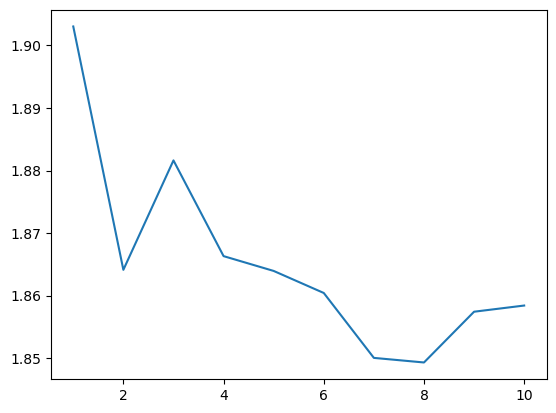

In [14]:
# train and plot:

epochs = 10
losses = train(model, train_data_emory , epochs, device)
plt.plot(np.arange(1,epochs+1),losses)

In [23]:
def compute_test_loss(model,loss_fn,data_loader,device,itos):
  model.eval()
  losses = []
  accs = []
  preds = [] ## predictions will be here
  prec = 0
  trues = [] ## true values will be here
  words = []
  pred_words = []
  for it,batch in tqdm(enumerate(data_loader),total=data_loader.__len__()):
    batch = {'texts' : batch['texts'].view(-1).to(device),
             'emotions': batch['emotions'].view(-1).to(device),
             'target_texts': batch['target_texts'].view(-1).to(device),
             'target_emotions': batch['target_emotions'].view(-1).to(device)}
    hidden = torch.zeros(80, requires_grad=True).to(device)
    inp_emotion = batch['emotions'][0]

    for t in range(len(batch['texts'])):
      inp_token = batch['texts'][t]
      target_token = batch['target_texts'][t]
      target_emotion = batch['target_emotions'][t]

      pt , pe, hidden = model.forward(inp_token,inp_emotion,hidden)
      loss1 = loss_fn(pe,target_emotion) + loss_fn(pt,target_token)
      pe = torch.argmax(pe)
      pt = torch.argmax(pt)
      inp_emotion = pe
      words.append(itos[target_token.item()] if target_token.item() in itos else '<unk>')
      pred_words.append(itos[pt.item()+2] if pt.item() in itos else "<unk>")
      preds.append(pe.item())
      trues.append(target_emotion.item())
      if pe == target_emotion:
        accs.append(1)
      else:
        accs.append(0)
      losses.append(loss1.item())
  
  print("average loss: ", sum(losses)/len(losses))
  print("average acc: ", sum(accs)/len(accs))
  return trues, preds, words, pred_words

In [24]:
trues, preds, words, pred_words = compute_test_loss(model,nn.CrossEntropyLoss(),test_loader_emory,device,itos_emory)

  0%|          | 0/99 [00:00<?, ?it/s]

average loss:  10.809680721671217
average acc:  0.24651863003387278


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
names = [f'{i}' for i in range(0,8)]
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))
print(confusion_matrix(trues,preds))

## to visually see how it compares:
l_ = {e:t for (t,e) in lookup_emory.items()}

l_[7] = "NE"
x1 = list(map(lambda e : l_[e],trues[:500]))
x2 = list(map(lambda e : l_[e],preds[:500]))
print(l_)
c = Counter(words) ## 
#print(c)
for a,b,c,d in zip(x1,x2,words[:500],pred_words[:500]):
  print(f"word: {c} -- emotion: {a} -- emotion predition: {b} -- word prediction: {d}")

              precision    recall  f1-score   support

           0       0.24      0.73      0.36      3735
           1       0.23      0.19      0.21      2403
           2       0.00      0.00      0.00      3587
           3       0.15      0.11      0.13      2003
           4       0.34      0.27      0.30      2300
           5       0.03      0.01      0.02      1273
           6       0.37      0.26      0.30      2053
           7       0.00      0.00      0.00      1245

    accuracy                           0.25     18599
   macro avg       0.17      0.20      0.16     18599
weighted avg       0.18      0.25      0.19     18599

[[2733  555    0  217  216    0   14    0]
 [1284  464    0  152  236   34  233    0]
 [2705  257    0  350  209   24   42    0]
 [1285  109    0  228  195   34  152    0]
 [1118  249    0  123  622    2  186    0]
 [ 716  185    0   64  103   13  192    0]
 [ 735   75    0  344  121  253  525    0]
 [ 799  125    0   93  126   24   78    0]]
{0: 

/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Anaconda3-2023.07-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
